# Road Flow Visualization by Country

This notebook analyzes and visualizes road network flows for a selected country. It integrates OD (Origin-Destination) matrices, road network data, and country boundaries to provide insights into the distribution and magnitude of flows for different vehicle types (cars, trucks, buses). The workflow includes data loading, OD matrix preparation, capacity estimation, flow assignment, per-edge vehicle estimation, visualization, and summary statistics. The output includes maps and tables summarizing flows for each road segment, with a focus on the selected country.


## 1. Imports and Configuration

This section imports all necessary Python libraries and utility functions, and loads the country boundaries dataset. It ensures the spatial data is in the correct coordinate reference system and filters the boundaries to the European region, preparing the context for subsequent road flow analysis.


In [1]:
# HIDE CODE
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import warnings
from pathlib import Path

import sys
from miraca_book.download import download

sys.path.append(str(Path().resolve().parent))

from utils.miraca_flow_utils import (
    compute_travel_time_kh, pick_col, compute_edge_capacity_cars, 
    od_flow_allocation_capacity_constrained, get_flow_on_edges, 
    plot_edges_by_flow_thickness, od_road_creation, 
    prepare_od_data, get_country_bounds, plot_flow_map, print_flow_statistics,
    load_europe_countries, convert_crs
)

warnings.filterwarnings('ignore')

outpath = Path('~/.miraca').expanduser() / "output"
outpath.mkdir(exist_ok=True, parents=True)
base_path = download('https://zenodo.org/records/18428552/files/MIRACA_Transport_Flow_Model.zip?download=1') / 'data'

In [2]:
# Load European countries using shared function
europe_countries = load_europe_countries(base_path)

Loaded 54 countries in Europe region


## 2. Load data and prepare OD matrices

This section loads the road network data, including edges and nodes, and OD (Origin-Destination) matrices for cars, trucks, and buses. It prepares the OD data for further analysis by cleaning and formatting the relevant columns, and creates a merged OD matrix with PCU equivalents and vehicle shares.


In [3]:
print('Loading road data...')
edges_gdf = convert_crs(gpd.read_parquet(base_path / "Infra_BE/belgium_road_edges.parquet"), 4326)
nodes_gdf = convert_crs(gpd.read_parquet(base_path / "Infra_BE/belgium_road_nodes.parquet"), 4326)
od_flows_trucks = pd.read_parquet(base_path / "ODs_BE/belgium_road_trucks_OD.parquet")
od_flows_cars = pd.read_parquet(base_path / "ODs_BE/belgium_road_cars_OD.parquet")
od_flows_buses = pd.read_parquet(base_path / "ODs_BE/belgium_road_buses_OD.parquet")
print('Data loaded.')

edges_gdf = compute_travel_time_kh(edges_gdf, speed_col='tag_maxspeed')
edge_src = pick_col(edges_gdf, ['from_id'])
edge_dst = pick_col(edges_gdf, ['to_id'])
node_id_col = pick_col(nodes_gdf, ['id'])

# Prepare OD data using helper function
od_cars = prepare_od_data(od_flows_cars, 'origin_node', 'dest_node', 'cars_vehicles')
od_buses = prepare_od_data(od_flows_buses, 'origin_node', 'dest_node', 'buses_vehicles')
od_trucks = prepare_od_data(od_flows_trucks, 'from_id', 'to_id', 'trucks_per_year')

# --- Create vehicles OD matrix with PCU equivalents and shares ---
# PCU factors
pcu_cars = 1.0
pcu_trucks = 3.0
pcu_buses = 3.0

vehicles_od_pcu = od_road_creation(od_cars, od_buses, od_trucks, pcu_cars, pcu_buses, pcu_trucks)

Loading road data...
Data loaded.


## 3. Compute Capacities and plot them

This section estimates per-edge vehicle capacities based on operational assumptions and traffic composition. It visualizes the number of vehicles per edge and sets up the network for flow assignment.


Traffic composition:
  Cars:   98.99% (2,772,355,295)
  Trucks: 0.54% (15,124,530)
  Buses:  0.47% (13,234,140)


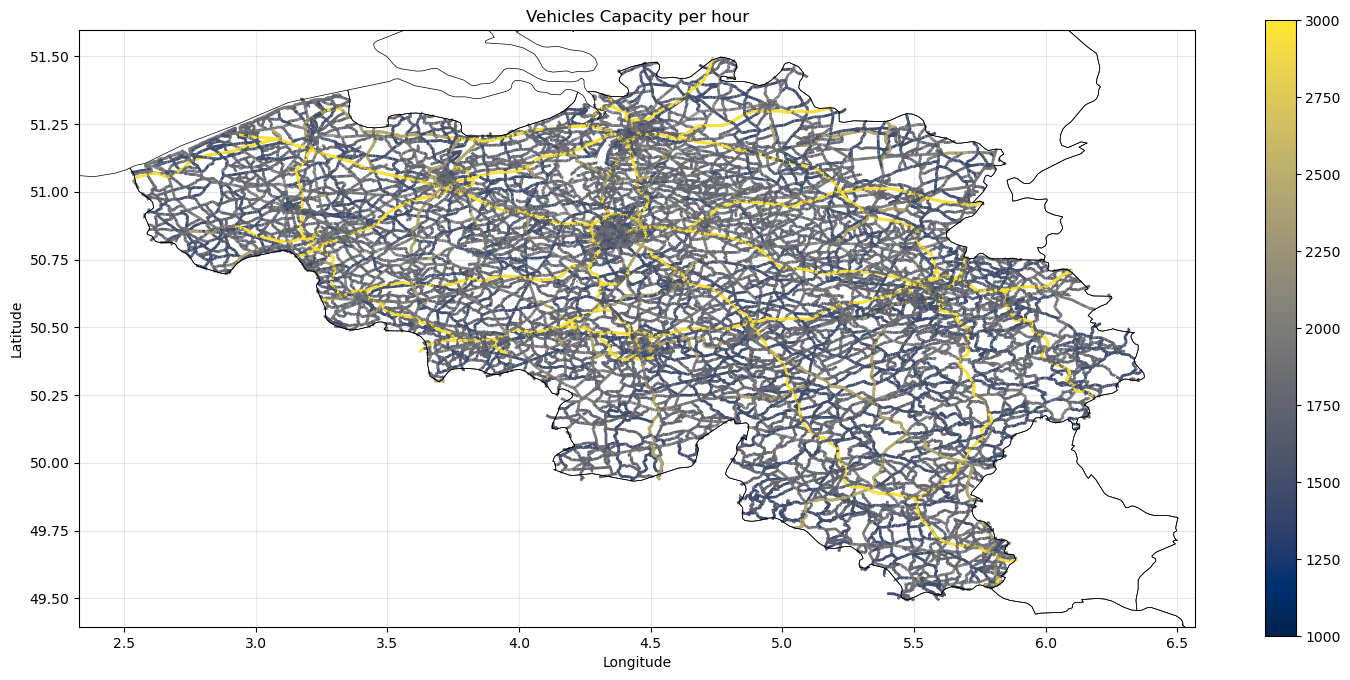

In [4]:
edges_gdf = edges_gdf.copy()
edges_gdf['edge_id'] = np.arange(len(edges_gdf), dtype=int)

network_df = pd.DataFrame({
    'from_node': edges_gdf[edge_src].astype(str).values,
    'to_node':   edges_gdf[edge_dst].astype(str).values,
    'edge_id':   edges_gdf['edge_id'].values,
    'travel_time': pd.to_numeric(edges_gdf['travel_time'], errors='coerce').fillna(1.0).astype(float).values,
    'CORRIDORS': edges_gdf['CORRIDORS'].values
})
      
network_df['pcu_flow'] = 0.0
network_df['cars'] = 0.0
network_df['buses'] = 0.0
network_df['trucks'] = 0.0

# --- Compute traffic composition from OD matrices ---
total_cars = od_cars['cars_vehicles'].sum() if 'cars_vehicles' in od_cars.columns else 0.0
total_trucks = od_trucks['trucks_per_year'].sum() if 'trucks_per_year' in od_trucks.columns else 0.0
total_buses = od_buses['buses_vehicles'].sum() if 'buses_vehicles' in od_buses.columns else 0.0
total_vehicles = total_cars + total_trucks + total_buses
if total_vehicles > 0:
    share_cars = total_cars / total_vehicles
    share_trucks = total_trucks / total_vehicles
    share_buses = total_buses / total_vehicles
else:
    share_cars = share_trucks = share_buses = 0.0
print(f"Traffic composition:")
print(f"  Cars:   {share_cars:.2%} ({total_cars:,.0f})")
print(f"  Trucks: {share_trucks:.2%} ({total_trucks:,.0f})")
print(f"  Buses:  {share_buses:.2%} ({total_buses:,.0f})")

cap_vehicles = compute_edge_capacity_cars(edges_gdf, tt_col='travel_time', share_cars=share_cars, share_trucks=share_trucks, share_buses=share_buses)
cap_arr_vehicles = np.asarray(cap_vehicles, dtype=float)
cap_arr_vehicles = np.where(np.isfinite(cap_arr_vehicles), cap_arr_vehicles, 0.0)
network_df['capacity_vehicles'] = cap_arr_vehicles

edges_gdf_copy = edges_gdf.copy()
edges_gdf_copy['num_vehicles'] = network_df['capacity_vehicles'] / (300 * 24)

# Get country bounds using helper function
SELECTED_COUNTRY = "Belgium"
belgium_row = europe_countries[europe_countries['NAME'].str.lower() == SELECTED_COUNTRY.lower()]
xlim, ylim = get_country_bounds(europe_countries, SELECTED_COUNTRY)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
edges_gdf_copy.plot(ax=ax, column='num_vehicles', cmap='cividis', linewidth=2, legend=True, vmin=1000, vmax=3000)
europe_countries.boundary.plot(ax=ax, color='black', linewidth=0.5)
ax.set_title('Vehicles Capacity per hour')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.grid(True, alpha=0.3)

## 4. Create network

This section builds the road network graph, filters edges by capacity, and prepares the network for flow assignment and further analysis.


In [5]:
thr_capacity = 1
# Filter out edges with capacity below threshold
network_df_filtered = network_df[(network_df['capacity_vehicles'] >= thr_capacity)].copy()
edges_gdf_copy = edges_gdf[edges_gdf['edge_id'].isin(network_df_filtered['edge_id'])].copy()
edges_gdf_copy = edges_gdf_copy.merge(
    network_df_filtered[['edge_id', 'capacity_vehicles']],
    on='edge_id', how='left'
    )

base_graph = ig.Graph.TupleList(
    network_df_filtered[['from_node', 'to_node', 'edge_id', 'travel_time']].itertuples(index=False, name=None),
    edge_attrs=['edge_id', 'travel_time'],
    directed=False
)

print(f"Network: {base_graph.vcount()} nodes, {base_graph.ecount()} edges in igraph object.")

# total capacities
total_cap_vehicles = network_df_filtered['capacity_vehicles'].sum()
print(f"Total Vehicle Capacity per year: {total_cap_vehicles:,.2f}")


Network: 162308 nodes, 187122 edges in igraph object.
Total Vehicle Capacity per year: 2,517,337,642,159.49


## 5. Assign flows to the network

This section assigns flows to the road network using a capacity-constrained allocation algorithm. It aggregates the assigned flows per edge, estimates the number of each vehicle type per edge, and merges the results into the network dataframe.


In [6]:
# Run capacity-constrained allocation for road vehicles
capacity_ods_vehicles, unassigned_paths_vehicles, filtered_network_df, progress_df = od_flow_allocation_capacity_constrained(
    flow_ods=vehicles_od_pcu,
    network_dataframe=network_df_filtered,
    flow_column='pcu_flow',
    cost_column='travel_time',
    path_id_column='edge_id',
    attribute_list=None,
    origin_id_column='from_node',
    destination_id_column='to_node',
    network_capacity_column='capacity_vehicles',
    directed=False,
    simple=False,
    store_edge_path=True,
    graph_base=base_graph,
    track_progress=True,
    early_stop_share=0.95
)

# Aggregate assigned flows per edge
if isinstance(capacity_ods_vehicles, list):
    assigned_df = pd.concat(capacity_ods_vehicles, ignore_index=True)
else:
    assigned_df = capacity_ods_vehicles

# --- OPTIMIZED: Compute vehicle flows per edge in a single pass ---
# Merge shares once, then explode and aggregate in one step
assigned_df = assigned_df.merge(
    vehicles_od_pcu[['from_node', 'to_node', 'share_cars', 'share_trucks', 'share_buses']],
    on=['from_node', 'to_node'], how='left'
)

# Pre-compute vehicle flows before explode (reduces computation after explode)
assigned_df['cars_on_edge'] = assigned_df['pcu_flow'] * assigned_df['share_cars'] / pcu_cars
assigned_df['trucks_on_edge'] = assigned_df['pcu_flow'] * assigned_df['share_trucks'] / pcu_trucks
assigned_df['buses_on_edge'] = assigned_df['pcu_flow'] * assigned_df['share_buses'] / pcu_buses

# Single explode operation
assigned_exploded = assigned_df[['edge_path', 'pcu_flow', 'cars_on_edge', 'trucks_on_edge', 'buses_on_edge']].explode('edge_path')
assigned_exploded = assigned_exploded.dropna(subset=['edge_path'])
assigned_exploded['edge_id'] = assigned_exploded['edge_path'].astype(int)

# Single groupby aggregation for all columns at once
edge_flows = assigned_exploded.groupby('edge_id', as_index=False).agg({
    'pcu_flow': 'sum',
    'cars_on_edge': 'sum',
    'trucks_on_edge': 'sum',
    'buses_on_edge': 'sum'
}).rename(columns={'pcu_flow': 'assigned_vehicles'})

# Single merge into filtered_network_df (combines all previous merges)
filtered_network_df = filtered_network_df.merge(
    edge_flows, on='edge_id', how='left'
).merge(
    edges_gdf[['edge_id', 'geometry']], on='edge_id', how='left'
)

# Fill NaN with 0 for all flow columns
flow_cols = ['assigned_vehicles', 'cars_on_edge', 'trucks_on_edge', 'buses_on_edge']
filtered_network_df[flow_cols] = filtered_network_df[flow_cols].fillna(0.0)

# Clean up intermediate variables
del assigned_exploded, edge_flows

[progress] iter=0 assigned_iter=2638876724.000 cum=2638876724.000 (0.9235) remaining=218554581.000 overcap_edges=0 next_flows=0


## 7. Create Flow Visualization

This section visualizes the assigned flows for all vehicles and by vehicle type (cars, trucks, buses) on the road network using maps. It also prints summary statistics for per-edge vehicle flows.


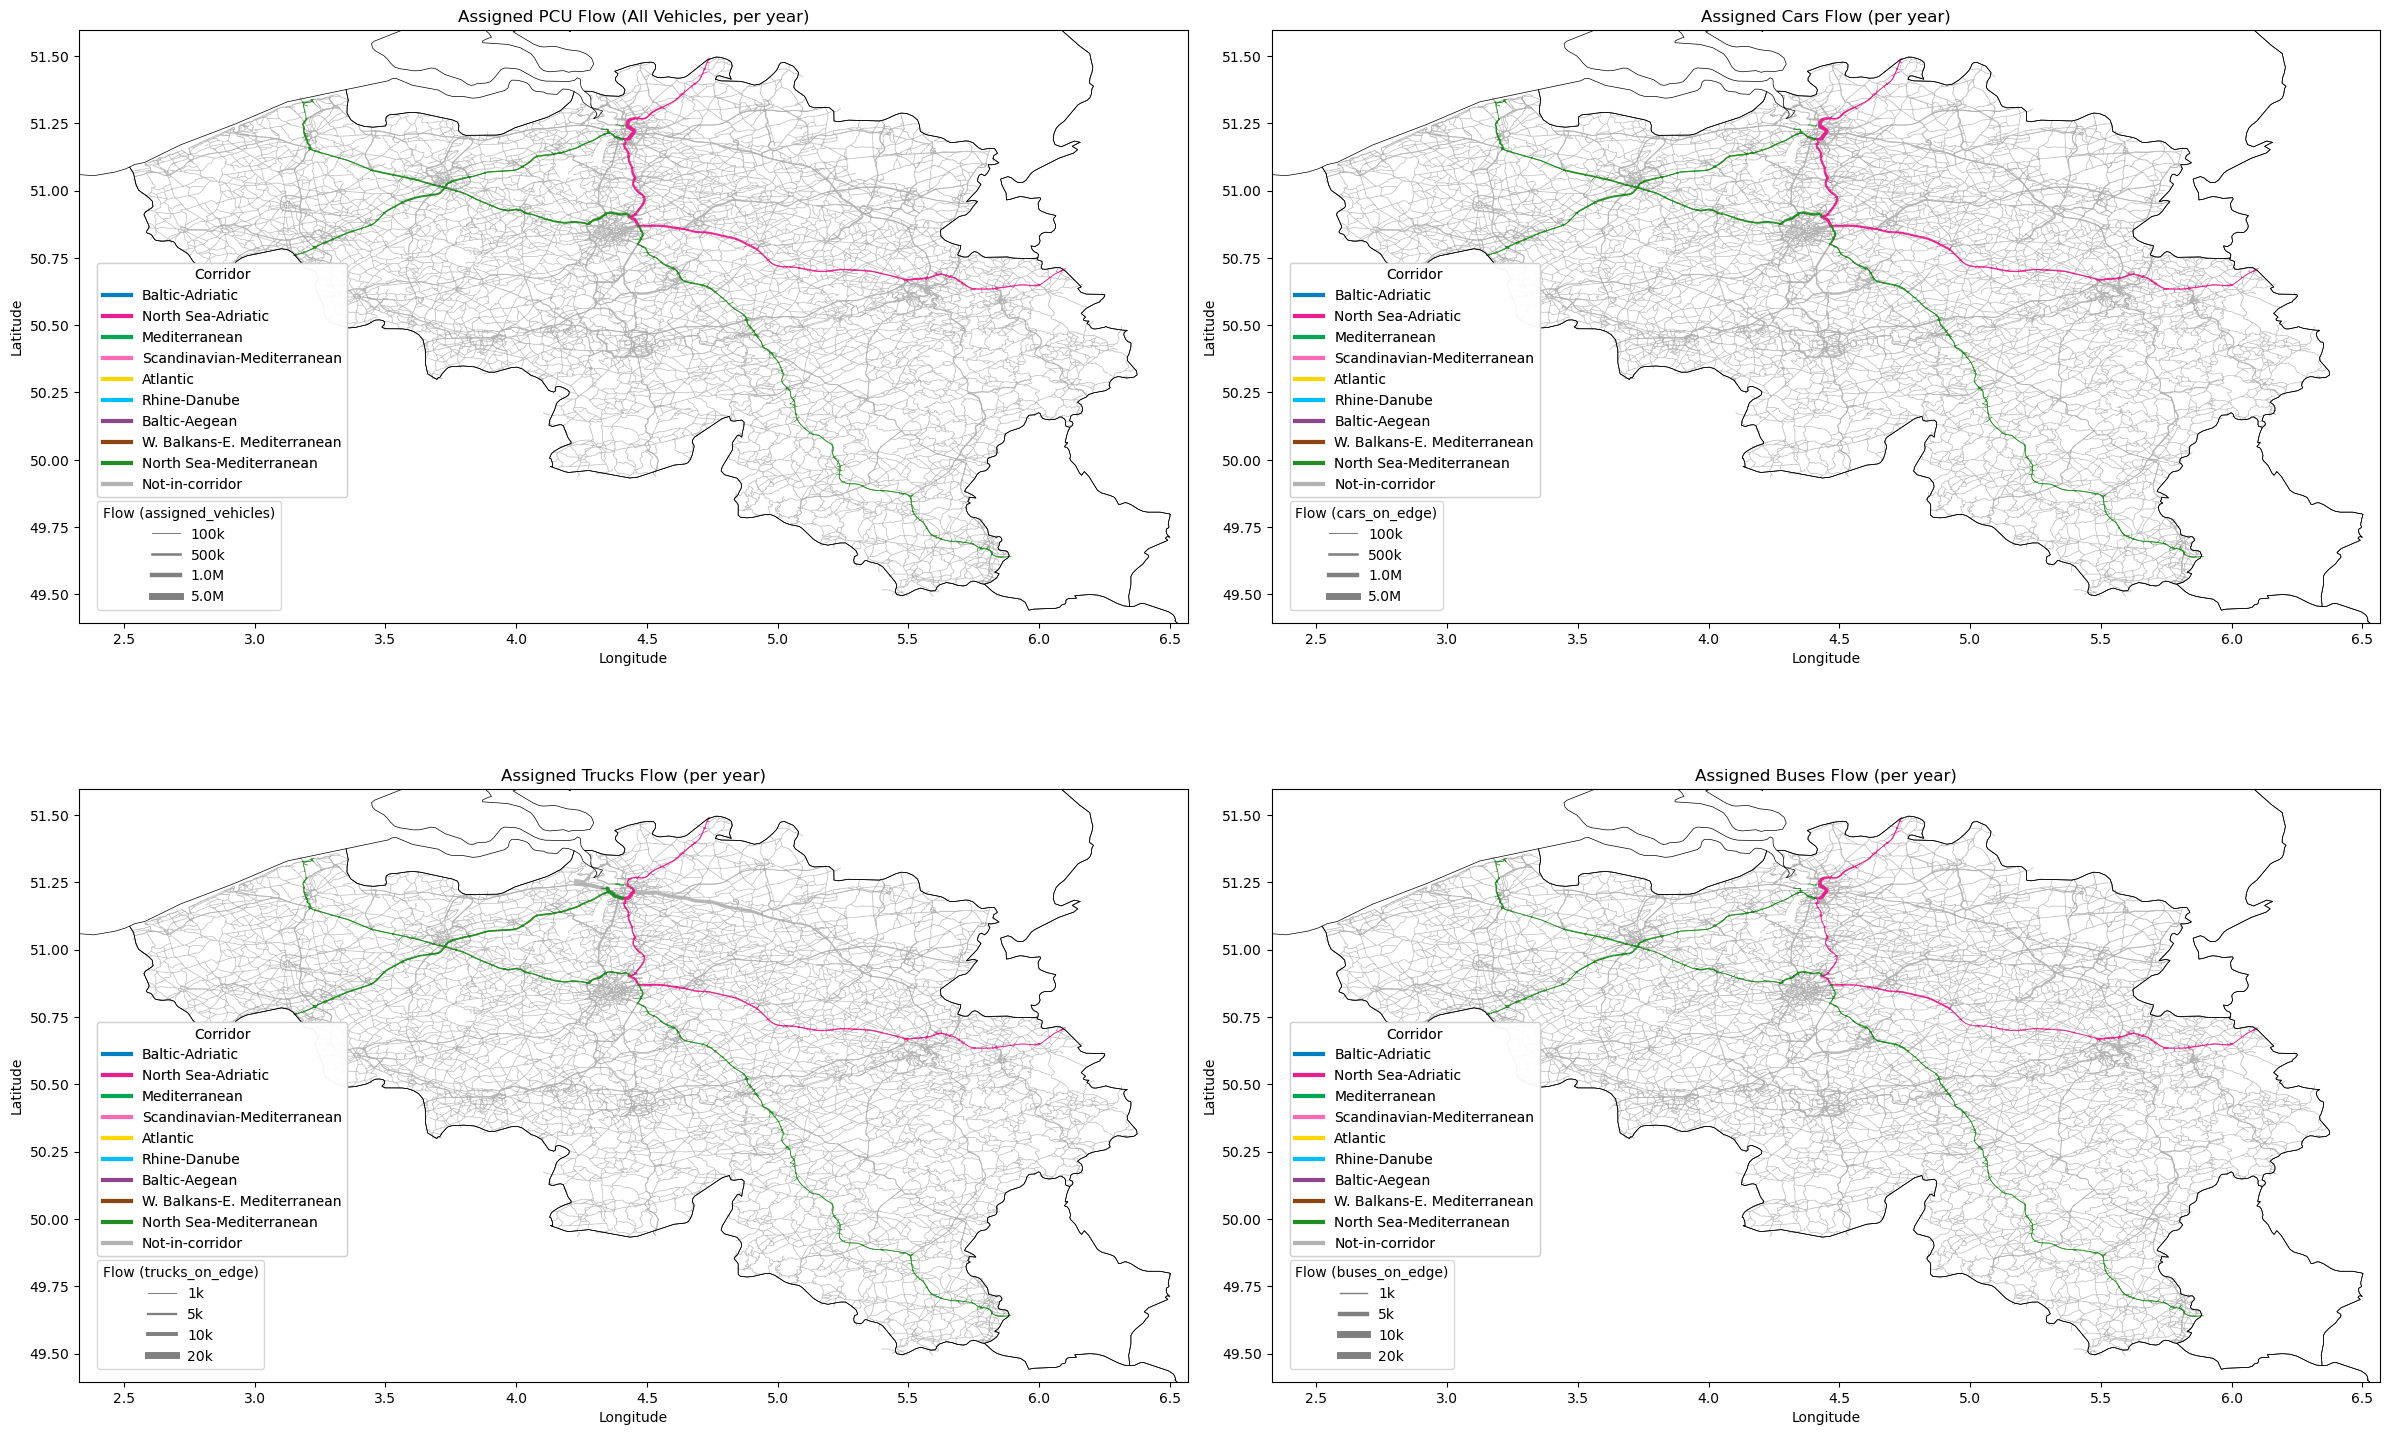

PER-EDGE FLOW STATISTICS
PCU (all):
  Total: 313,118,854,466
  Max:   168,140,149
  Mean:  1,673,340.68
  Nonzero edges: 108239 / 187122

Cars:
  Total: 305,882,906,780
  Max:   165,609,292
  Mean:  1,634,671.00
  Nonzero edges: 104751 / 187122

Trucks:
  Total: 1,132,263,748
  Max:   1,936,751
  Mean:  6,050.94
  Nonzero edges: 34106 / 187122

Buses:
  Total: 1,279,718,814
  Max:   842,162
  Mean:  6,838.95
  Nonzero edges: 62070 / 187122



In [7]:
# --- Plot flows for all vehicles and by vehicle type ---
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
axes = axes.flatten()

# Define plot configurations: (ax_index, flow_col, title, legend_ticks)
plot_configs = [
    (0, 'assigned_vehicles', 'Assigned PCU Flow (All Vehicles, per year)', [100000, 500000, 1000000, 5000000]),
    (1, 'cars_on_edge', 'Assigned Cars Flow (per year)', [100000, 500000, 1000000, 5000000]),
    (2, 'trucks_on_edge', 'Assigned Trucks Flow (per year)', [1000, 5000, 10000, 20000]),
    (3, 'buses_on_edge', 'Assigned Buses Flow (per year)', [1000, 5000, 10000, 20000]),
]

for ax_idx, flow_col, title, legend_ticks in plot_configs:
    plot_flow_map(
        axes[ax_idx], filtered_network_df, flow_col=flow_col, corridors_col='CORRIDORS',
        countries_gdf=europe_countries, xlim=xlim, ylim=ylim,
        title=title, legend_ticks=legend_ticks
    )

plt.savefig(outpath / f'road_network_{SELECTED_COUNTRY.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# --- Statistics for vehicle flows per edge ---
print_flow_statistics(
    filtered_network_df,
    columns=['assigned_vehicles', 'cars_on_edge', 'trucks_on_edge', 'buses_on_edge'],
    labels=['PCU (all)', 'Cars', 'Trucks', 'Buses']
)